# Pipeline for the anomaly detection on the SKAB using ARIMA fault detection algorithm

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

The idea behind this algorithm is to use ARIMA weights as features for the anomaly detection algorithm. Using discrete differences of weight coefficients for different heuristic methods for obtaining function, which characterized the state (anomaly, not anomaly) using a threshold. 

Links at [PyPi](https://pypi.org/project/arimafd/), [GitHub](https://github.com/waico/arimafd) and [paper](https://waico.ru)

In [ ]:
# libraries importing
import os
import sys
import pickle
import warnings

from arimafd import Anomaly_detection

sys.path.append("..")
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

In [ ]:
if os.path.exists(r"tensors.pickle"):
    with open(r"tensors.pickle", "rb") as f:
        tensors = pickle.load(f)
else:
    tensors = []
    for df in list_of_df:
        a = Anomaly_detection(df.iloc[:, :-2])
        tensors.append(a.generate_tensor(ar_order=100))
    with open(r"tensors.pickle", "wb") as handle:
        pickle.dump(tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
No_metric = 5
window = 150
window_insensitivity = 20

predicted_cp = []
for i, df in enumerate(list_of_df):
    acci = df.changepoint
    a = Anomaly_detection(df)
    a.tensor = tensors[i]
    a.proc_tensor(
        No_metric=No_metric,
        window=window,
        window_insensitivity=window_insensitivity,
    )
    predicted_cp.append(a.bin_metric)

### Results visualization

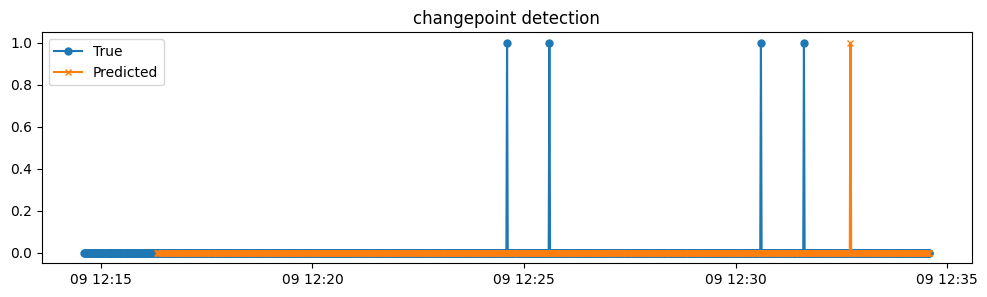

In [ ]:
# [donotremove]
true_cp = [df.changepoint for df in list_of_df]
plot_results((true_cp[0], predicted_cp[0]))

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

not implemented

### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 78
A number of FPs = 65
Average time 0 days 00:01:08.941176470


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  10.65
LowFP  -  4.95
LowFN  -  14.08
